In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import datetime
import geopandas as gpd
import pandas as pd

from segment_speed_utils.project_vars import (SEGMENT_GCS, analysis_date,
                                              SHARED_GCS,
                                              PROJECT_CRS)
from segment_speed_utils import helpers, segment_calcs, wrangle_shapes


In [2]:
df = pd.read_parquet(
    f"{SEGMENT_GCS}vp_sjoin/vp_road_segments_{analysis_date}"
)

In [3]:
vp_with_projected = pd.read_parquet(
    f"{SEGMENT_GCS}projection/vp_projected_roads_{analysis_date}.parquet"
)

In [4]:
df2 = pd.merge(
    df, 
    vp_with_projected,
    on = ["linearid", "mtfcc", "segment_sequence", 
          "trip_instance_key", "vp_idx"],
    how = "inner"
)

In [5]:
subset_vp = df2.vp_idx.unique().tolist()

In [6]:
vp_usable = pd.read_parquet(
    f"{SEGMENT_GCS}vp_usable_{analysis_date}",
    columns = ["vp_idx", "location_timestamp_local"],
    filters = [[("vp_idx", "in", subset_vp)]]
)

In [7]:
vp_usable = segment_calcs.convert_timestamp_to_seconds(
    vp_usable, 
    ["location_timestamp_local"]
).drop(columns = "location_timestamp_local")

In [8]:
df3 = pd.merge(
    df2,
    vp_usable,
    on = "vp_idx",
    how = "inner"
)

In [9]:
min_shape = df3.groupby(["linearid", "mtfcc", "segment_sequence",
             "trip_instance_key"]).agg(
    {"shape_meters": "min",
    "location_timestamp_local_sec": "min"}).reset_index()

max_shape = df3.groupby(["linearid", "mtfcc", "segment_sequence",
             "trip_instance_key"]).agg(
    {"shape_meters": "max", 
    "location_timestamp_local_sec": "max"}).reset_index()

In [10]:
df4 = pd.merge(
    min_shape.rename(columns = {
        "shape_meters": "min_shape_meters",
        "location_timestamp_local_sec": "min_sec",
    }),
    max_shape.rename(columns = {
        "shape_meters": "max_shape_meters",
        "location_timestamp_local_sec": "max_sec"
    }),
    on = ["linearid", "mtfcc", "segment_sequence", "trip_instance_key"],
    how = "inner"
).query('min_shape_meters != max_shape_meters')

In [11]:
df5 = segment_calcs.derive_speed(
    df4,
    distance_cols = ("min_shape_meters", "max_shape_meters"),
    time_cols = ("min_sec", "max_sec")
)

<AxesSubplot:>

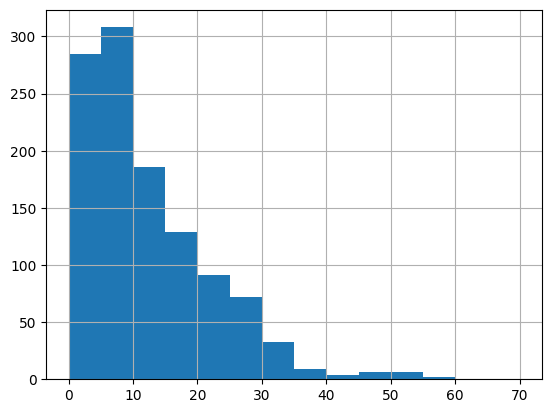

In [12]:
df5.speed_mph.hist(bins = range(0, 75, 5))